01:58:34 --- Epoch: 0	Train loss: 0.2322	Valid loss: 0.0841	Train accuracy: 97.55	Valid accuracy: 97.45
01:59:29 --- Epoch: 1	Train loss: 0.0792	Valid loss: 0.0776	Train accuracy: 97.97	Valid accuracy: 97.58
02:00:24 --- Epoch: 2	Train loss: 0.0560	Valid loss: 0.0541	Train accuracy: 98.72	Valid accuracy: 98.36
02:01:20 --- Epoch: 3	Train loss: 0.0436	Valid loss: 0.0552	Train accuracy: 98.81	Valid accuracy: 98.35
02:02:16 --- Epoch: 4	Train loss: 0.0375	Valid loss: 0.0521	Train accuracy: 99.19	Valid accuracy: 98.47
02:03:13 --- Epoch: 5	Train loss: 0.0290	Valid loss: 0.0479	Train accuracy: 99.26	Valid accuracy: 98.52
02:04:12 --- Epoch: 6	Train loss: 0.0264	Valid loss: 0.0510	Train accuracy: 99.41	Valid accuracy: 98.40
02:05:08 --- Epoch: 7	Train loss: 0.0231	Valid loss: 0.0528	Train accuracy: 99.46	Valid accuracy: 98.48
02:06:05 --- Epoch: 8	Train loss: 0.0204	Valid loss: 0.0480	Train accuracy: 99.53	Valid accuracy: 98.69
02:07:01 --- Epoch: 9	Train loss: 0.0173	Valid loss: 0.0539	Trai

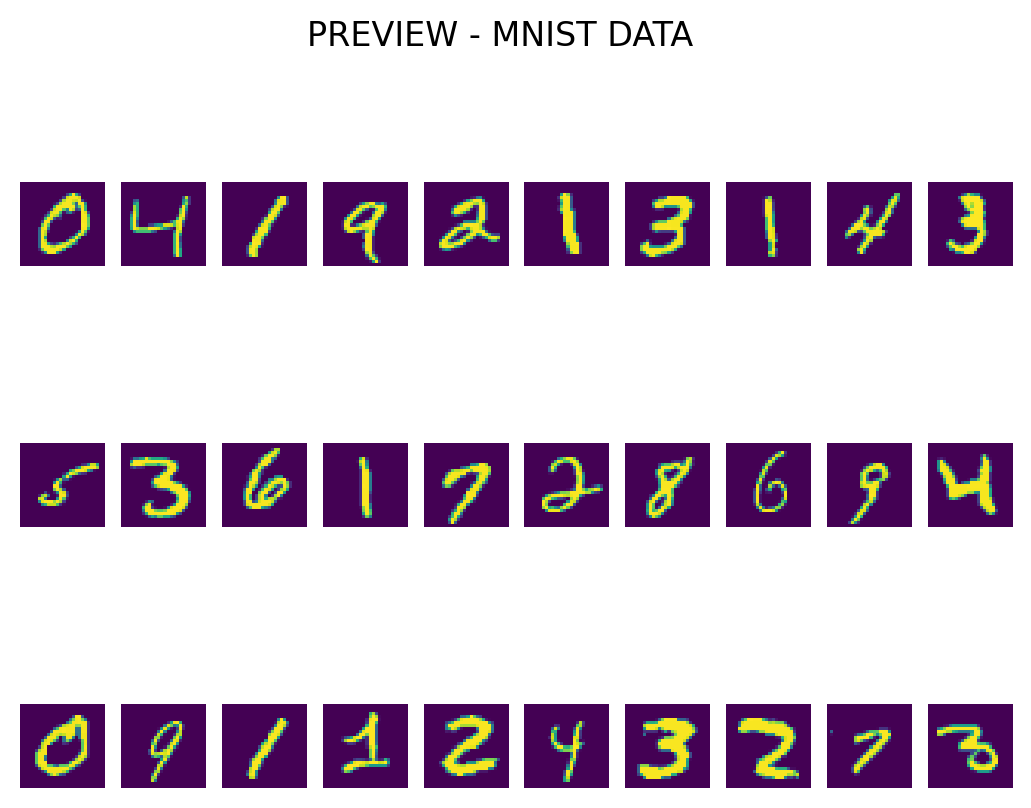

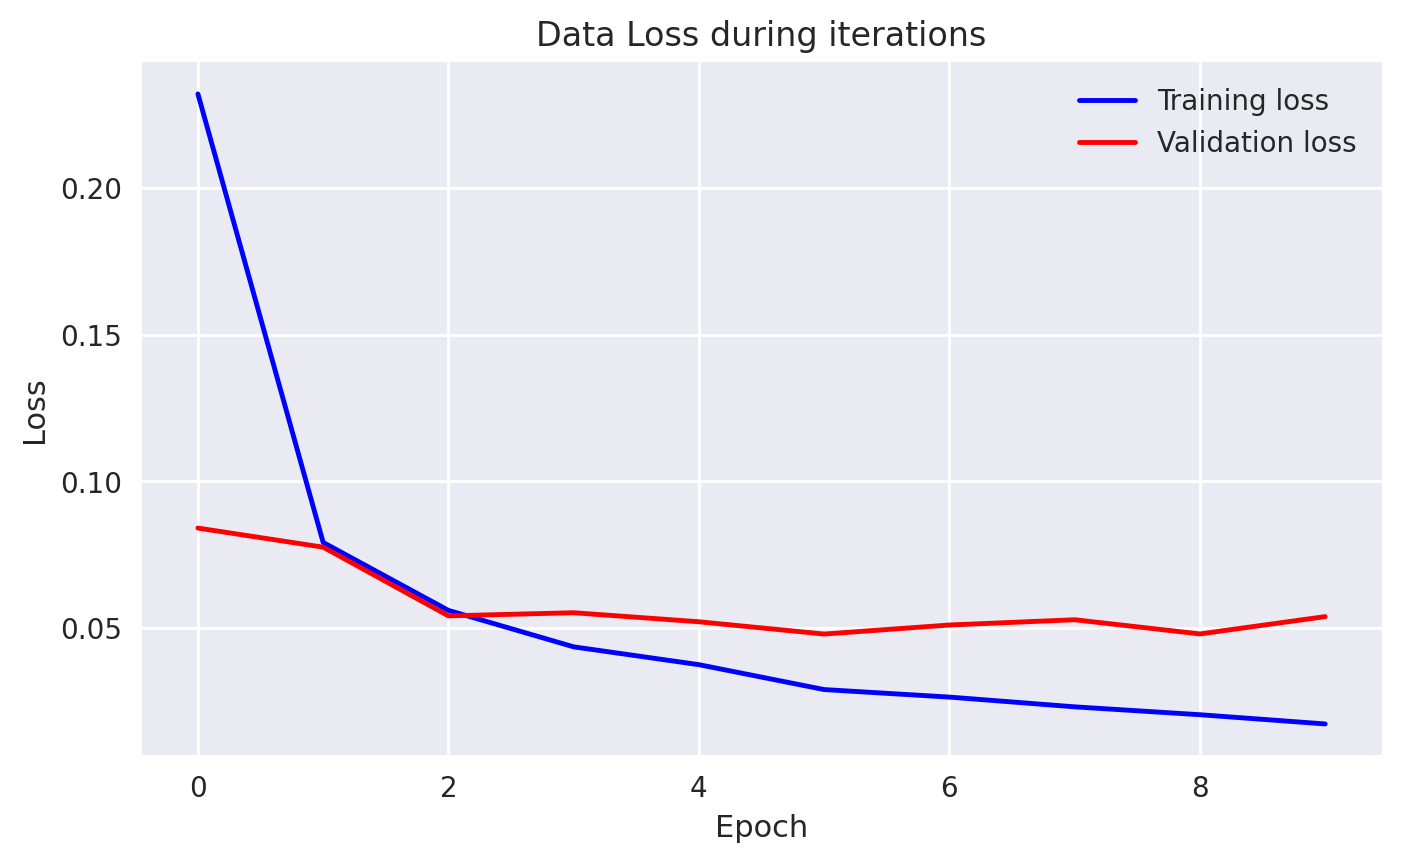

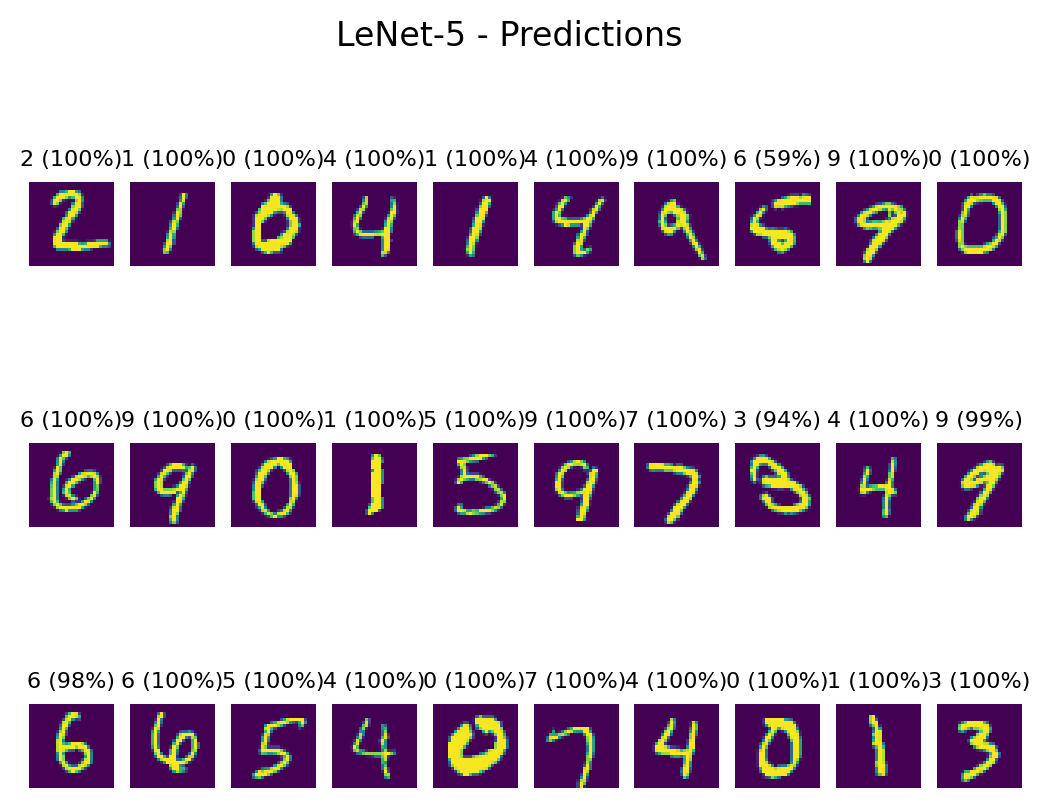

In [197]:
from csv import reader
import numpy as np
import pandas as pd
import torch.nn as torchn
import torch.nn.functional as torchf
from torch.utils.data import DataLoader
from datetime import datetime 
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
rate_learning = 0.001
total_epochs = 10                                                #Number of epochs
NUM_CLASS = 10
if torch.cuda.is_available():
  SYSTEM = 'cuda' 
else :
  SYSTEM ='cpu'
image_in_rows = 10
num_rows = 3

def get_accuracy(model, data_loader, system):                   #To find the accuracy % of model
   
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(system)
            y_true = y_true.to(system)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def train(train_loader, model, criterion, optimizer, system):   #Loading training dataset
   

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(system)
        y_true = y_true.to(system)
    
       
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

      
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)     #loss during training
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, system):         #Loading the testing/validating dataset 
  
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(system)
        y_true = y_true.to(system)

   
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, system, print_every=1):
 
   
    best_loss = 1e10
    train_losses = []
    test_losses = []
 
   
    for epoch in range(0, epochs):

     
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, system)
        train_losses.append(train_loss)

      
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, system)
            test_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, system=system)
            valid_acc = get_accuracy(model, valid_loader, system=system)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, test_losses)
    
    return model, optimizer, (train_losses, test_losses)

def plot_losses(train_losses, test_losses):                      #To display the losses during validation and training
   
    
   
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    test_losses = np.array(test_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(test_losses, color='red', label='Validation loss')
    ax.set(title="Data Loss during iterations", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()                                          
    
   
    plt.style.use('default')                                  

transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])


def load_csv(file):                                                   #fetching csv files for train and test dataset 
	data1 = list()

	with open(file, 'r') as file:
		csv_reader = reader(file)

		for row in csv_reader:

			if not row:

				continue
			data1.append(row)

	return data1

file1 = 'mnist_train.csv' 

data1 = load_csv(file1)

file2='mnist_test.csv'

data2 = load_csv(file2)

train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

test_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)


train_loader = DataLoader(dataset=train_dataset,                    #loading training and validation dataset
                          batch_size=30, 
                          shuffle=True)

valid_loader = DataLoader(dataset=test_dataset, 
                          batch_size=30, 
                          shuffle=False)

fig = plt.figure()                                                  #Preview of MNIST data
for index in range(1, image_in_rows * num_rows + 1):
    plt.subplot(num_rows, image_in_rows, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('PREVIEW - MNIST DATA');

class LeNet5(torchn.Module):                                                            #Implementing LeNet5 Model for image processing

    def __init__(self, num_class):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = torchn.Sequential(            
            torchn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            torchn.Tanh(),
            torchn.AvgPool2d(kernel_size=2),
            torchn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            torchn.Tanh(),
            torchn.AvgPool2d(kernel_size=2),
            torchn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            torchn.Tanh()
        )

        self.classifier = torchn.Sequential(
            torchn.Linear(in_features=120, out_features=84),
            torchn.Tanh(),
            torchn.Linear(in_features=84, out_features=num_class),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probability = torchf.softmax(logits, dim=1)
        return logits, probability

model = LeNet5(NUM_CLASS).to(SYSTEM)  
optimizer = torch.optim.Adam(model.parameters(), lr=rate_learning)                #optimizing the model using adam
criterion = torchn.CrossEntropyLoss()
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, total_epochs, SYSTEM)

fig = plt.figure()                                                                  #Plotting Prediction based on the LeNet5 model
for index in range(1, image_in_rows * num_rows + 1):
    plt.subplot(num_rows, image_in_rows, index)
    plt.axis('off')
    plt.imshow(test_dataset.data[index])
    with torch.no_grad():
        model.eval()
        _, probability = model(test_dataset[index][0].unsqueeze(0))
    title = f'{torch.argmax(probability)} ({torch.max(probability * 100):.0f}%)'    #Plotting accuracy % for each prediction
    plt.title(title, fontsize=8)
fig.suptitle('LeNet-5 - Predictions');